In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import argrelextrema
from tqdm.notebook import tqdm
import mplfinance as mpf

import sys

sys.path.insert(0,'/Users/orentapiero/btc_research/')

from btc_functions.glassnode import *
from btc_functions.import_data import get_glassnode_price,get_glassnode_data
from btc_functions.variable_list_urls import *
from btc_functions.utilities import strided_app,strided_app2

plt.rcParams['figure.figsize'] = [18, 10]
sns.set()

In [2]:
def bar_create(ohlc,what = 'transfers_volume_sum',th=5):
    df = ohlc.copy()
    group = pd.Series(index = df.index, dtype = float, name = 'group')
    N = len(group)

    t = ohlc[what] #100*np.log(ohlc['Close']/ohlc['Open'])
    ts = 0
    idx = []

    for i, x in enumerate(t):
        ts += x
        if np.abs(ts) > th:
            idx.append(i)
            ts = 0.0
            continue

    group.iloc[idx]  = idx
    group.fillna(method = 'bfill',inplace = True)
    group.fillna(method = 'ffill',inplace = True)

    df.loc[:,'group'] = group
    df.loc[:,'Time'] = df.index

    fTime = df.groupby('group')['Time'].first()
    lTime = df.groupby('group')['Time'].last()
    Time_ = pd.concat([fTime,lTime],axis = 1)
    Time_.columns = ['open','close']
    Time_.index = Time_.close
    Time_.loc[:,'dt'] = (Time_.close-Time_.open).dt.total_seconds()


    Open = df.groupby('group')['Open'].first()
    High = df.groupby('group')['High'].max()
    Low = df.groupby('group')['Low'].min()
    Close = df.groupby('group')['Close'].last()

    newOhlc = pd.concat([Open,High,Low,Close],axis = 1)
    newOhlc.index = lTime
    return newOhlc,group

def check_direction(R):
    pos = (R>0) & (R.shift(1)>0)
    neg = (R<=0) & (R.shift(1)<=0)

    mask = pos | neg
    return mask.sum()/mask.count()

In [3]:
Urls['transfers_volume_sum'] = 'https://api.glassnode.com/v1/metrics/transactions/transfers_volume_sum'
Urls['ssr'] = 'https://api.glassnode.com/v1/metrics/indicators/ssr'

In [86]:
ohlc = get_glassnode_price()
ohlc = ohlc.rename(columns = {'o':'Open','h':'High','l':'Low','c':'Close'})
ohlc = ohlc.loc[:'2019']

selected = ['marketcap_usd',
            'mvrv_z_score',
            'sopr',
            'sopr_adjusted',
            'puell_multiple',
            'net_unrealized_profit_loss',
            'ssr',
            'transfers_volume_sum',
            'transfers_volume_exchanges_net',
            'dormancy_flow',
            'reserve_risk']

features = get_glassnode_data(selected,Urls)
features = features.loc[:'2019']

  0%|          | 0/11 [00:00<?, ?it/s]

cannot get ssr.


# Puell multiple

- Cycle top > 4
- Local Top < 4 and >3
- Cycle bottom < 0.5

In [87]:
def local_min_max(df,col,L):
    df[col+'_ma_'+str(L)] = df[col].rolling(L).mean()
    x = df[col+'_ma_'+str(L)].copy()
    
    Lmin = x.loc[(x.shift(1)>x) & (x.shift(-1)>x)].rename(col+'_min')
    Lmax = x.loc[(x.shift(1)<x) & (x.shift(-1)<x)].rename(col+'_max')
    
    df_ = pd.concat([df,Lmin,Lmax],axis = 1)
    
    return df_

In [88]:
df = pd.concat([ohlc.Close,features['puell_multiple']],axis = 1).dropna()
df = local_min_max(df,'puell_multiple',20).copy()
df['log_puell_ma'] = np.log(df['puell_multiple_ma_20'])

<AxesSubplot:xlabel='t'>

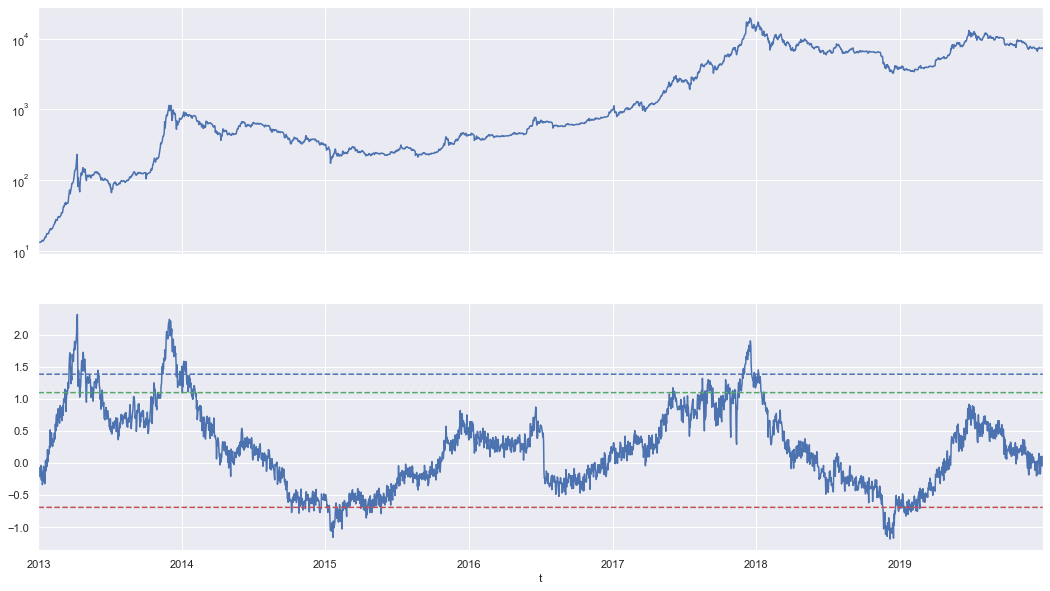

In [89]:
cycle_top = pd.Series(4,index = df.index)
local_top = pd.Series(3,index = df.index)
cycle_bottom = pd.Series(0.5,index = df.index)

f,a = plt.subplots(nrows = 2, sharex = True)
df['Close'].plot(ax = a[0],logy = True)

np.log(df['puell_multiple']).plot(ax = a[1])
np.log(cycle_top).plot(ax = a[1],style = 'b--')
np.log(local_top).plot(ax = a[1],style = 'g--')
np.log(cycle_bottom).plot(ax = a[1],style = 'r--')


In [ ]:
df['R']=100*(df.Close/df.Close.shift(1)-1)
# df = df.dropna().copy()

df['q_puell'] = pd.qcut(df['log_puell_ma'].diff(20).shift(1),3)

avg = df.groupby('q_puell')['R'].apply(lambda x: x.mean()/x.std()).rename('std_avg')
prc = df.groupby('q_puell')['R'].apply(lambda x: x[x>0].count()/x.count()).rename('prc')
cnt = df.groupby('q_puell')['R'].count().rename('N')

pd.concat([avg,prc,cnt],axis=1)


In [ ]:
print('above 4:',
      df.loc[df.puell_multiple.shift(1)>4,'R'].mean())
print('between 3 and 4:',
      df.loc[(df.puell_multiple.shift(1)<4) & (df.puell_multiple.shift(1)>3) ,'R'].mean())
print('between 0.5 and 3:',
      df.loc[(df.puell_multiple.shift(1)<3) & (df.puell_multiple.shift(1)>0.5) ,'R'].mean())
print('below 0.5:',
      df.loc[(df.puell_multiple.shift(1)<0.5),'R'].mean())

In [ ]:
print('above 4:',
      df.loc[df.puell_multiple.shift(1)>4,'R'].mean()/df.loc[df.puell_multiple.shift(1)>4,'R'].std())
print('between 3 and 4:',
      df.loc[(df.puell_multiple.shift(1)<4) & (df.puell_multiple.shift(1)>3) ,'R'].mean()/df.loc[(df.puell_multiple.shift(1)<4) & (df.puell_multiple.shift(1)>3) ,'R'].std())
print('between 0.5 and 3:',
      df.loc[(df.puell_multiple.shift(1)<3) & (df.puell_multiple.shift(1)>0.5) ,'R'].mean()/df.loc[(df.puell_multiple.shift(1)<3) & (df.puell_multiple.shift(1)>0.5) ,'R'].std())
print('below 0.5:',
      df.loc[(df.puell_multiple.shift(1)<0.5),'R'].mean()/df.loc[(df.puell_multiple.shift(1)<0.5),'R'].std())


In [ ]:
OHLC = pd.concat([ohlc,features[['transfers_volume_sum','puell_multiple']]],axis=1).dropna().copy()
newOhlc,group = bar_create(OHLC,what = 'transfers_volume_sum',th = 6.5*1e6)
newOhlc = pd.concat([newOhlc,OHLC['puell_multiple']],axis=1).dropna()


In [ ]:
cols = ['Open','High','Low','Close']
f,a = plt.subplots(nrows = 2)
mpf.plot(np.log(newOhlc.loc['2017',cols]),type='candle',ax = a[0])
a[1].plot(newOhlc.loc['2017','puell_multiple'])

In [ ]:
newOhlc['R'] = 100*(newOhlc.Close/newOhlc.Close.shift(1)-1)

print('above 4:',
      newOhlc.loc[newOhlc.puell_multiple.shift(1)>4,'R'].mean())
print('between 3 and 4:',
      newOhlc.loc[(newOhlc.puell_multiple.shift(1)<4) & (newOhlc.puell_multiple.shift(1)>3) ,'R'].mean())
print('between 0.5 and 3:',
      newOhlc.loc[(newOhlc.puell_multiple.shift(1)<3) & (newOhlc.puell_multiple.shift(1)>0.5) ,'R'].mean())
print('below 0.5:',
      newOhlc.loc[(newOhlc.puell_multiple.shift(1)<0.5),'R'].mean())

# Reserve risk

<AxesSubplot:>

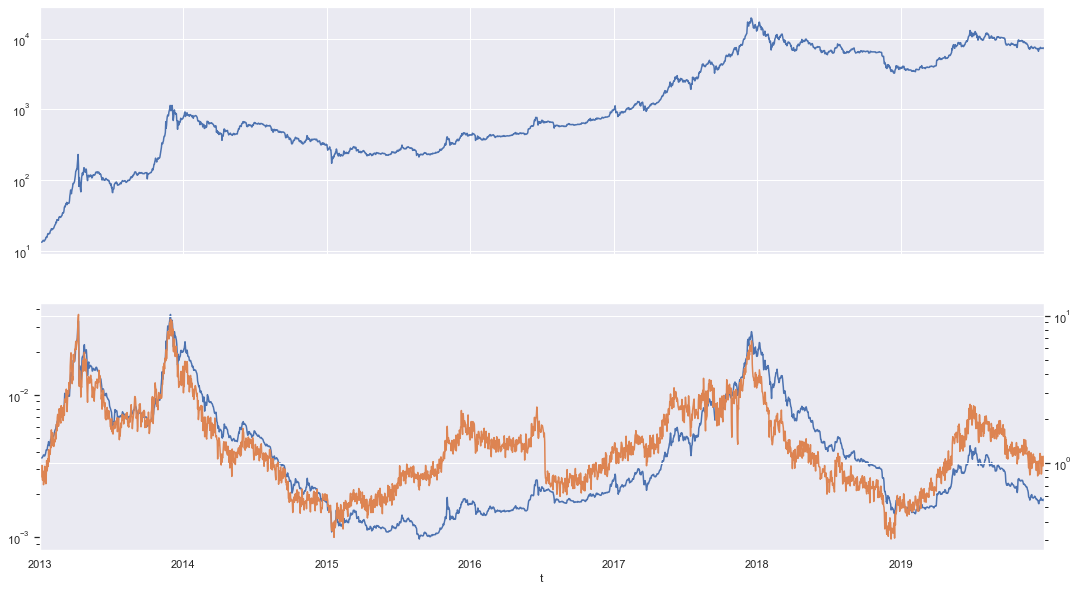

In [14]:
df = pd.concat([ohlc.Close,features[['reserve_risk','puell_multiple']]],axis = 1).dropna()


f,a = plt.subplots(nrows = 2, sharex = True)
df['Close'].plot(ax = a[0],logy = True)

df['reserve_risk'].plot(ax = a[1],logy=True)
df['puell_multiple'].plot(ax = a[1],logy=True,secondary_y=True)


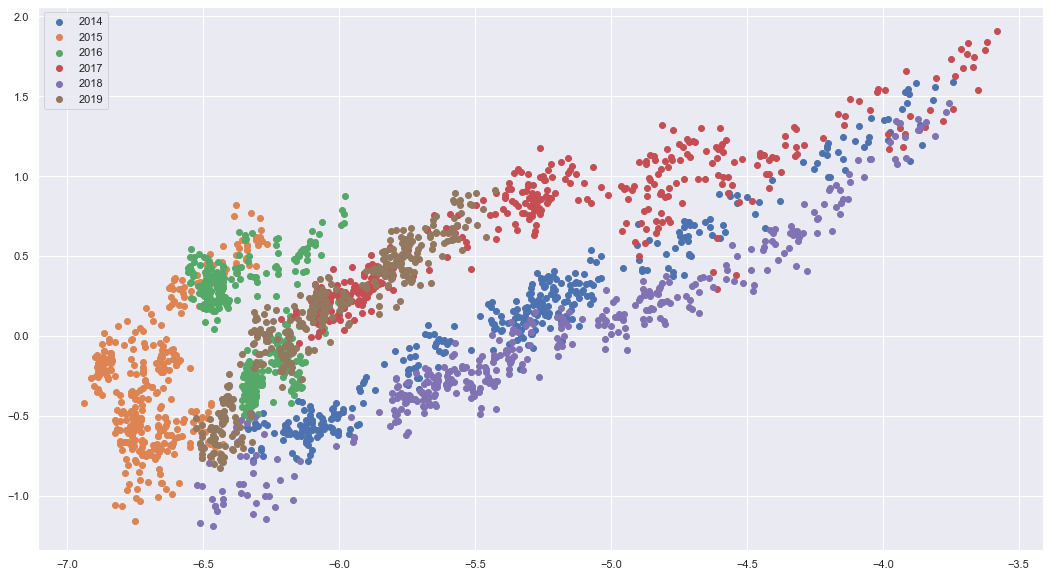

In [31]:
years = np.unique(df.index.year)

for y in years[1:]:
    plt.scatter(np.log(df.loc[str(y)].reserve_risk),
                np.log(df.loc[str(y)].puell_multiple),label = y)
    
plt.legend()

<AxesSubplot:xlabel='t'>

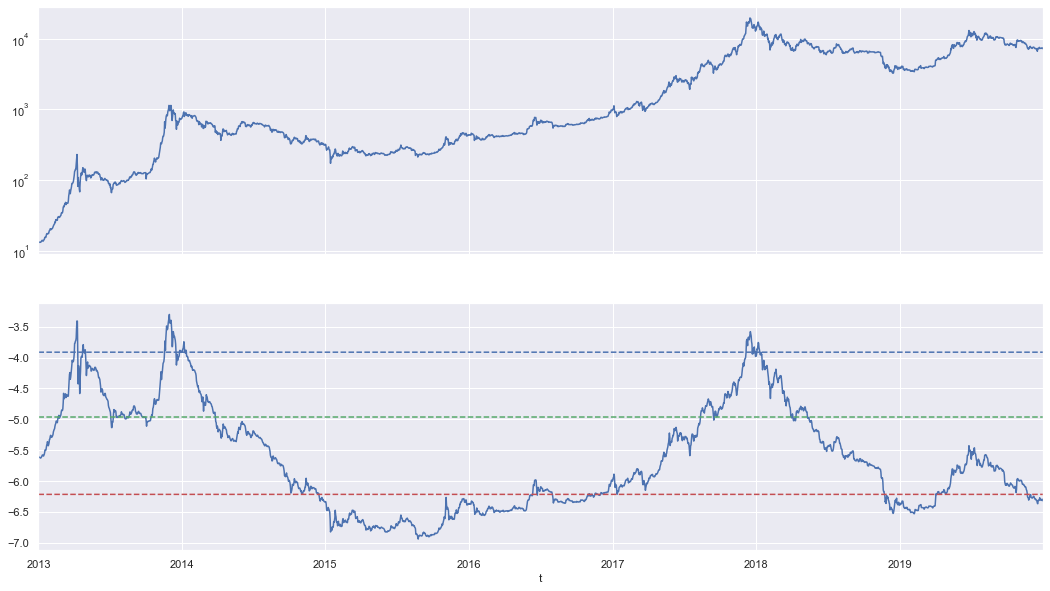

In [32]:
cycle_top = pd.Series(0.02,index = df.index)
local_top = pd.Series(0.007,index = df.index)
cycle_bottom = pd.Series(0.002,index = df.index)

f,a = plt.subplots(nrows = 2, sharex = True)
df['Close'].plot(ax = a[0],logy = True)

np.log(df['reserve_risk']).plot(ax = a[1])
np.log(cycle_top).plot(ax = a[1],style = 'b--')
np.log(local_top).plot(ax = a[1],style = 'g--')
np.log(cycle_bottom).plot(ax = a[1],style = 'r--')


In [33]:
df['R']=100*(df.Close/df.Close.shift(1)-1)

print('above 0.02:',
      df.loc[df.reserve_risk.shift(1)>0.02,'R'].mean())
print('between 0.02 and 0.007:',
      df.loc[(df.reserve_risk.shift(1)<0.02) & (df.reserve_risk.shift(1)>0.007) ,'R'].mean())
print('between 0.007 and 0.002:',
      df.loc[(df.reserve_risk.shift(1)<0.007) & (df.reserve_risk.shift(1)>0.002) ,'R'].mean())
print('below 0.002:',
      df.loc[(df.reserve_risk.shift(1)<0.002),'R'].mean())

above 0.02: -0.9143459834042467
between 0.02 and 0.007: 0.974704039681219
between 0.007 and 0.002: 0.2669585401449922
below 0.002: 0.19535049021444956


In [54]:
OHLC = pd.concat([ohlc,features[['transfers_volume_sum','reserve_risk']]],axis=1).dropna().copy()
newOhlc,group = bar_create(OHLC,what = 'transfers_volume_sum',th = 3.5*1e6)
newOhlc = pd.concat([newOhlc,OHLC['reserve_risk']],axis=1).dropna()


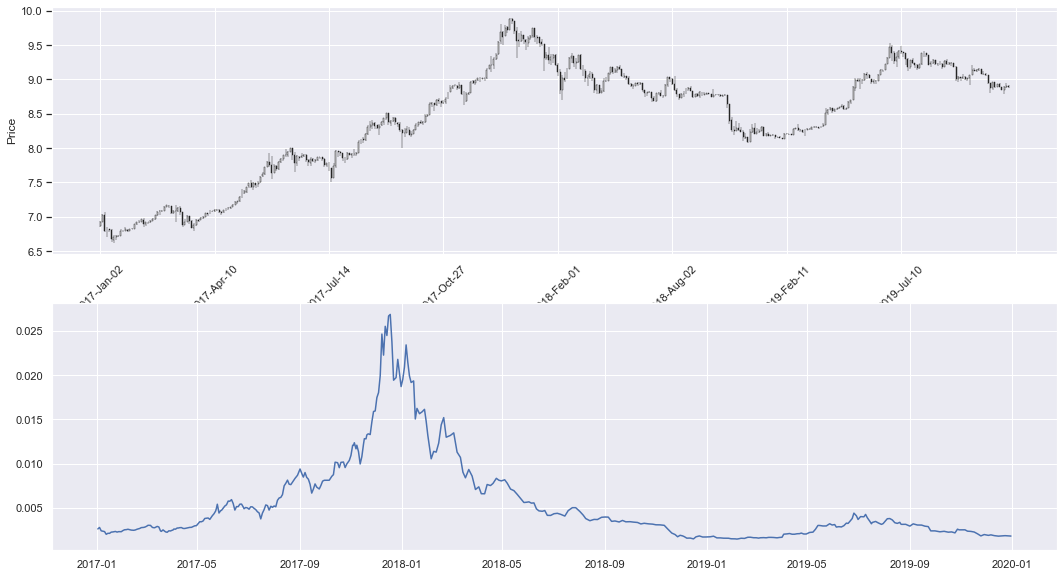

In [55]:
cols = ['Open','High','Low','Close']
f,a = plt.subplots(nrows = 2)
mpf.plot(np.log(newOhlc.loc['2017':'2019',cols]),type='candle',ax = a[0])
a[1].plot(newOhlc.loc['2017':'2019','reserve_risk'])

In [56]:
newOhlc['R']=100*(newOhlc.Close/newOhlc.Close.shift(1)-1)

print('above 0.02:',
      newOhlc.loc[newOhlc.reserve_risk.shift(1)>0.02,'R'].mean())
print('between 0.02 and 0.007:',
      newOhlc.loc[(newOhlc.reserve_risk.shift(1)<0.02) & (newOhlc.reserve_risk.shift(1)>0.007) ,'R'].mean())
print('between 0.007 and 0.002:',
      newOhlc.loc[(newOhlc.reserve_risk.shift(1)<0.007) & (newOhlc.reserve_risk.shift(1)>0.002) ,'R'].mean())
print('below 0.002:',
      newOhlc.loc[(newOhlc.reserve_risk.shift(1)<0.002),'R'].mean())

above 0.02: -1.0255915208734552
between 0.02 and 0.007: 2.8311342921276372
between 0.007 and 0.002: 0.8799413414873575
below 0.002: 0.5445817658759498


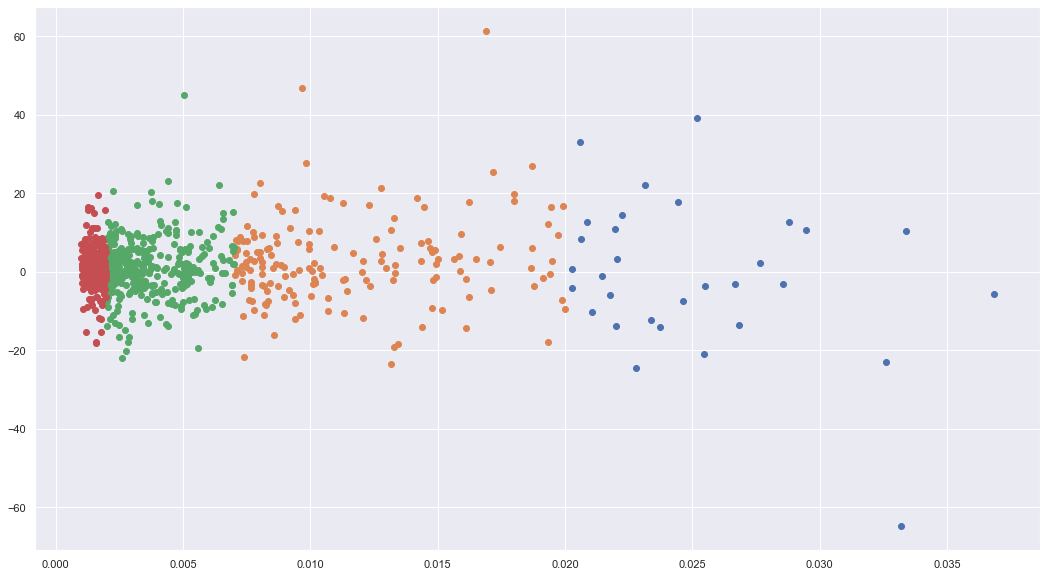

In [57]:
newOhlc['LRR'] = newOhlc.reserve_risk.shift(1)

plt.scatter(newOhlc.loc[newOhlc['LRR']>0.02,'LRR'],
            newOhlc.loc[newOhlc['LRR']>0.02,'R'])

plt.scatter(newOhlc.loc[(newOhlc['LRR']<0.02) & (newOhlc['LRR']>0.007),'LRR'],
            newOhlc.loc[(newOhlc['LRR']<0.02) & (newOhlc['LRR']>0.007),'R'])

plt.scatter(newOhlc.loc[(newOhlc['LRR']<0.007) & (newOhlc['LRR']>0.002),'LRR'],
            newOhlc.loc[(newOhlc['LRR']<0.007) & (newOhlc['LRR']>0.002),'R'])

plt.scatter(newOhlc.loc[(newOhlc['LRR']<0.002),'LRR'],
            newOhlc.loc[(newOhlc['LRR']<0.002),'R'])


# Adjusted SOPR

<AxesSubplot:xlabel='t'>

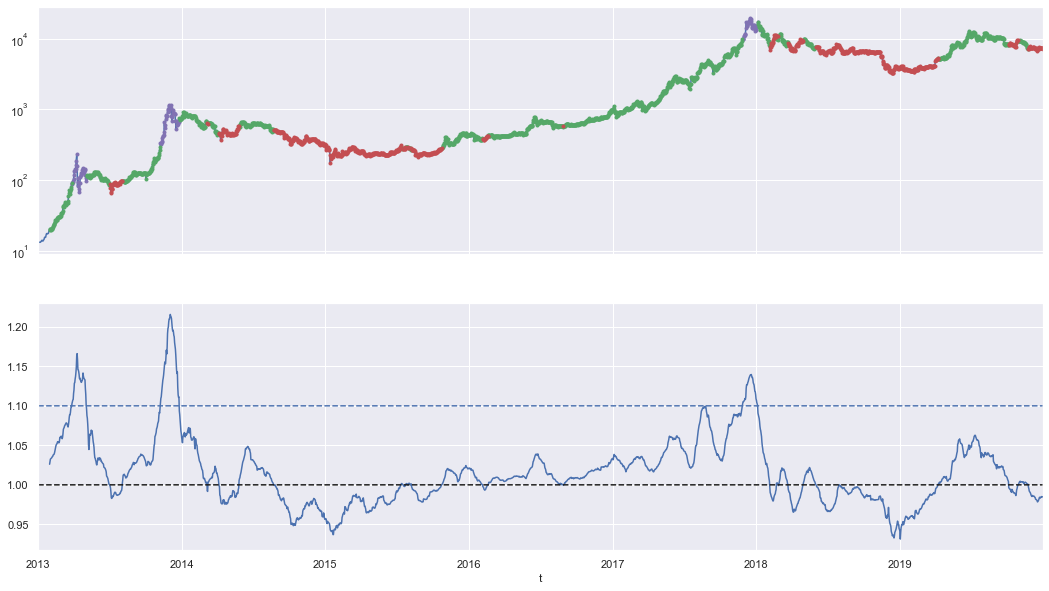

In [74]:
df = pd.concat([ohlc.Close,features[['reserve_risk','puell_multiple','sopr_adjusted']]],axis = 1).dropna()
df['sopr_adjusted_ma'] = df['sopr_adjusted'].rolling(30).mean()

cycle_top = pd.Series(1.1,index = df.index)
cycle_bottom = pd.Series(1.,index = df.index)


f,a = plt.subplots(nrows = 2, sharex = True)
df['Close'].plot(ax = a[0],logy = True)
df['Close'].loc[df.sopr_adjusted_ma>1.1].plot(ax = a[0],logy = True,style = 'm.')
df['Close'].loc[(df.sopr_adjusted_ma<1.1) & (df.sopr_adjusted_ma>1)].plot(ax = a[0],logy = True,style = 'g.')
df['Close'].loc[(df.sopr_adjusted_ma<1)].plot(ax = a[0],logy = True,style = 'r.')

df['sopr_adjusted_ma'].plot(ax = a[1])
cycle_top.plot(ax = a[1],style = 'b--')
cycle_bottom.plot(ax = a[1],style = 'k--')


In [67]:
df['R']=100*(df.Close/df.Close.shift(1)-1)

print('above 1.1:',
      df.loc[df.sopr_adjusted_ma.shift(1)>0.02,'R'].mean())
print('between 1.1 and 1.0:',
      df.loc[(df.sopr_adjusted_ma.shift(1)<1.1) & (df.sopr_adjusted_ma.shift(1)>1.) ,'R'].mean())
print('below 1:',
      df.loc[(df.sopr_adjusted_ma.shift(1)<1.),'R'].mean())

above 1.1: 0.34349855068317586
between 1.1 and 1.0: 0.3657317567159199
below 1: 0.08158381937293982


<AxesSubplot:xlabel='t'>

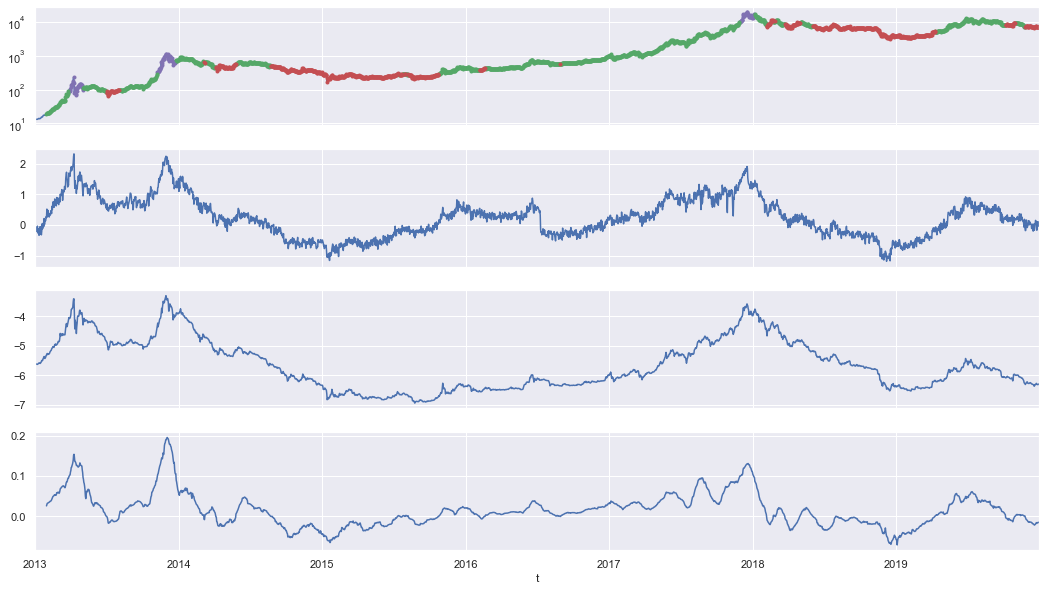

In [85]:
f,a = plt.subplots(nrows = 4, sharex = True)
df['Close'].plot(ax = a[0],logy = True)
df['Close'].loc[df.sopr_adjusted_ma>1.1].plot(ax = a[0],logy = True,style = 'm.')
df['Close'].loc[(df.sopr_adjusted_ma<1.1) & (df.sopr_adjusted_ma>1)].plot(ax = a[0],logy = True,style = 'g.')
df['Close'].loc[(df.sopr_adjusted_ma<1)].plot(ax = a[0],logy = True,style = 'r.')

np.log(df['puell_multiple']).plot(ax = a[1])
np.log(df['reserve_risk']).plot(ax = a[2])
np.log(df['sopr_adjusted_ma']).plot(ax = a[3])


In [84]:
df[['puell_multiple','reserve_risk','sopr_adjusted_ma']].corr()


,puell_multiple,reserve_risk,sopr_adjusted_ma
puell_multiple,1.000000,0.892491,0.881169
reserve_risk,0.892491,1.000000,0.758557
sopr_adjusted_ma,0.881169,0.758557,1.000000


# Entity 

<AxesSubplot:xlabel='t'>

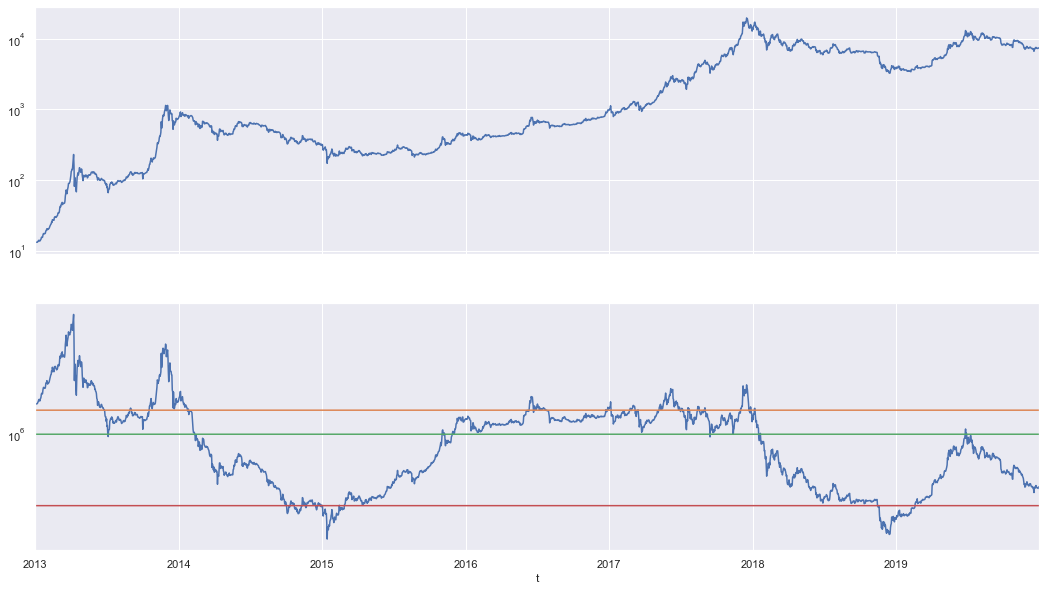

In [100]:
df = pd.concat([ohlc.Close,features[['reserve_risk','puell_multiple','sopr_adjusted','dormancy_flow']]],axis = 1).dropna()
df['sopr_adjusted_ma'] = df['sopr_adjusted'].rolling(30).mean()

cycle_top = pd.Series(1500000,index = df.index)
local_top = pd.Series(1000000,index = df.index)
cycle_bottom = pd.Series(300000,index = df.index)

f,a = plt.subplots(nrows = 2, sharex = True)
df['Close'].plot(ax = a[0],logy = True)
df['dormancy_flow'].plot(ax = a[1],logy = True)

cycle_top.plot(ax = a[1],logy = True)
local_top.plot(ax = a[1],logy = True)
cycle_bottom.plot(ax = a[1],logy = True)


In [101]:
df['R']=100*(df.Close/df.Close.shift(1)-1)

print('above 1,500,000:',
      df.loc[df.dormancy_flow.shift(1)>1500000,'R'].mean())
print('between 1,500,000 and 1,000,000:',
      df.loc[(df.dormancy_flow.shift(1)<1500000) & (df.dormancy_flow.shift(1)>1000000) ,'R'].mean())
print('between 1,000,000 and 300,000:',
      df.loc[(df.dormancy_flow.shift(1)<1000000) & (df.dormancy_flow.shift(1)>300000) ,'R'].mean())
print('below 300,000:',
      df.loc[(df.dormancy_flow.shift(1)<300000),'R'].mean())

above 1,500,000: 1.1110977334827845
between 1,500,000 and 1,000,000: 0.44776347266917554
between 1,000,000 and 300,000: 0.06800252101400657
below 300,000: 0.014754819090005216
